# Imports

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import torch
torch.set_float32_matmul_precision('high')
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from utils.env import *
from utils.data import *
from train import *
device = torch.device('cpu') # faster than using GPU

# Experiment Settings
Settings are based on the training procedure that produced the RL agent experimental results in the paper.  
Original experiments were performed on a M1 iMac running MacOS Sonoma

In [2]:
seed = 96470
torch.manual_seed(seed)
set_random_seed(seed)

# GENERATOR
path = './runs/Jul02_17-23-02_aidf-svr-gpu03_rq_10/'
wgt_filename = 'generator.pt'

### Generator params

In [3]:
events_path = path
params = get_params_from_events(events_path)
for key, value in params.items():
    for key, value in value.items():
        if key in globals(): continue
        globals()[key] = value
data_params, model_params, train_params = get_params_dicts(vars().copy())

### RL Params

In [4]:
# ENV
n_training_steps = 1e7
env_params = {'interest_rate': 0.0,
              'transaction_cost': 0.0005,
              'max_long': 1.0,
              'max_short': -1.0,
              'trading_calendar': 'NYSE',
              'sample_len': 1300,
              'window_len': 50,
              'hist_len': 50,
              'n_periods': 1250}

# AGENT TYPE
policy_kwargs = dict(
    activation_fn=torch.nn.Tanh,
    net_arch=[64, 64, 32],
)
arguments = {
    'device': device,
    'gae_lambda': 0.9,
    'vf_coef': 1.0,
    'n_steps': 1250*50,
    'batch_size': 250,
    'learning_rate': 3e-5,
    'clip_range': 0.03,
    'policy_kwargs':policy_kwargs
}

### Robust noise

In [5]:
# get generator
generator = get_trained_generator(model_params, data_params, path, filename=wgt_filename, device=device)
df = pd.read_csv('./data/spx_20231229.csv', index_col=0, parse_dates=True)
path_generator = MA_path_generator(generator, df, '1995-01-01', '2022-10-19', ma_p, seed=seed)

# Dot-com bubble burst
# garch_start_date = '1999-01-01'
# garch_end_date = '2003-12-31'
# df_robust, _ = gaussianize_data(df[garch_start_date:garch_end_date].copy(), 0)
# ma_model = arch.arch_model(df_robust.loc[:,'gaussianized'], mean=MEAN_MODEL, p=ma_p, q=Q_CONST, rescale=True)
# res1 = ma_model.fit(update_freq=0)

# 2008 GFC
garch_start_date = '2008-07-01'
garch_end_date = '2009-06-30'
df_robust, _ = gaussianize_data(df[garch_start_date:garch_end_date].copy(), 0)
ma_model = arch.arch_model(df_robust.loc[:,'gaussianized'], mean=MEAN_MODEL, p=ma_p, q=Q_CONST, rescale=True)
res2 = ma_model.fit(update_freq=0)

# Average of the two
# res3 = res1
# res3.params = (res1.params + res2.params) / 2

res = res2

path_generator.res = res # replace the MA model parameters
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 251.62857905639368
            Iterations: 25
            Function evaluations: 575
            Gradient evaluations: 25
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                       ARCH   Log-Likelihood:               -251.629
Distribution:                  Normal   AIC:                           545.257
Method:            Maximum Likelihood   BIC:                           619.292
                                        No. Observations:                  251
Date:                Fri, Jul 05 2024   Df Residuals:                      251
Time:                        07:29:00   Df Model:                            0
                            Volatility Model                            
     

### Get all objects

In [6]:
# get env
env = get_rl_env(path_generator, env_params, seed=seed)
env.plot_episode_freq = 1000000

# get agent
agent = PPO('MlpPolicy', env, verbose=0, tensorboard_log='./runs', seed=seed, **arguments)

/Users/luchungi/opt/anaconda3/envs/signature/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


# Training

In [7]:
agent.learn(n_training_steps)

E1 / S1250: Baseline Wealth = 1.8763 / Agent Final Wealth = 0.5134 / Average Weights and Std: [ 1.04494731 -0.04494731] / [0.73157332 0.73157332]
E2 / S2500: Baseline Wealth = 1.9742 / Agent Final Wealth = 0.6683 / Average Weights and Std: [ 1.05158477 -0.05158477] / [0.72372313 0.72372313]
E3 / S3750: Baseline Wealth = 1.7730 / Agent Final Wealth = 0.6157 / Average Weights and Std: [ 1.01876414 -0.01876414] / [0.71653777 0.71653777]
E4 / S5000: Baseline Wealth = 1.3204 / Agent Final Wealth = 0.5442 / Average Weights and Std: [0.99817075 0.00182925] / [0.73083736 0.73083736]
E5 / S6250: Baseline Wealth = 0.7002 / Agent Final Wealth = 0.6305 / Average Weights and Std: [0.99859841 0.00140159] / [0.70963587 0.70963587]
E6 / S7500: Baseline Wealth = 0.7148 / Agent Final Wealth = 0.8182 / Average Weights and Std: [ 1.02768385 -0.02768385] / [0.71733319 0.71733319]
E7 / S8750: Baseline Wealth = 1.7607 / Agent Final Wealth = 0.5003 / Average Weights and Std: [ 1.05902636 -0.05902636] / [0.707

# Evaluation

In [8]:
# get env
env_params['n_periods'] = len(df) - env_params['window_len']
env_params['stride'] = len(df)
spx_env = get_spx_data_env('./data/spx_20231229.csv', env_params)
evaluate_policy(agent, spx_env, n_eval_episodes=1, deterministic=True)

/Users/luchungi/opt/anaconda3/envs/signature/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/luchungi/opt/anaconda3/envs/signature/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


E1 / S7249: Baseline Wealth = 9.7047 / Agent Final Wealth = 2.1876 / Average Weights and Std: [0.86989172 0.13010828] / [0.79454964 0.79454964]
Not enough periods in real data for episode. Need 7299 but only have 0


/Users/luchungi/Google Drive/Programming/Git/Sig-MMD-SGM/utils/env.py:377: RuntimeWarning: underflow encountered in cast
  window = np.array(self.episode_path[self.real_data_current_period-(self.window_len-1):self.real_data_current_period+1]).reshape(-1).astype(np.float32)


(0.782803170582838, 0.0)

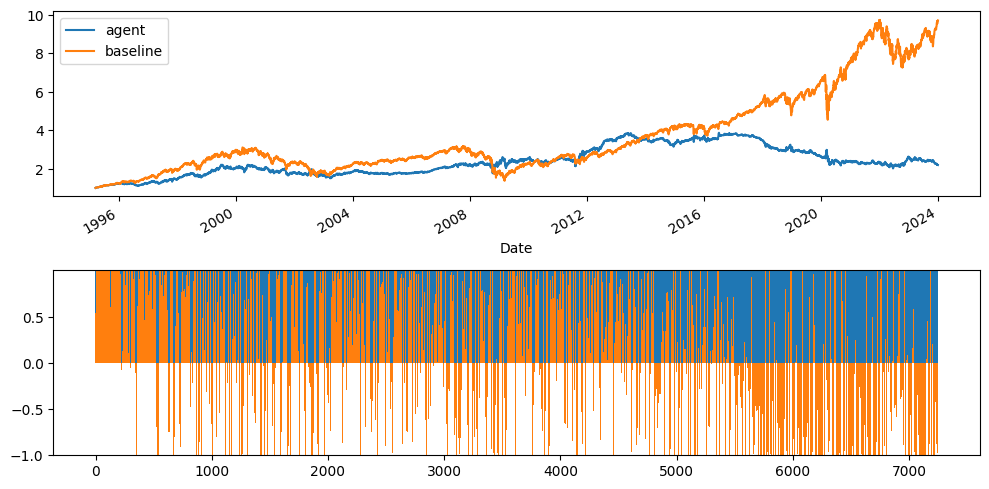

In [9]:
spx_env.plot()

In [9]:
csv_path = agent.logger.dir + '/data.csv'
df_spx = pd.read_csv(csv_path, index_col=0, parse_dates=True)

dates = [('1995-03-14', '2023-12-28'), ('2000-03-24', '2002-10-09'), ('2007-10-09', '2008-11-20'), ('2020-02-19', '2020-03-23')]
periods = ['Full dataset', 'Dot-com bubble burst', '2008 GFC', 'Covid']

table = perf_table(df_spx, dates, periods)
table

,Ann. return,Volatility,Sharpe ratio,Max drawdown
Full dataset,0.027209,0.156457,0.173932,-0.653508
Dot-com bubble burst,-0.061077,0.186754,-0.327561,-0.304519
2008 GFC,-0.004219,0.284126,-0.014901,-0.292941
Covid,0.289247,0.70434,0.428519,-0.151833
